In [234]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense

!pip install ta
import ta

pd.options.mode.chained_assignment = None


In [236]:
def preprocess(company, sc):
  #print(company.to_string())
  company = sc.fit_transform(company)
  company = pd.DataFrame(company)
  #df.columns = ['open', 'high', 'low', 'close', 'volume', 'Name']


  
  company = np.array(company)

  #Separate into X and y, in the target y we only want the closing price
  X = []
  y = []

  num_features = company.shape[1]

  for i in company:
    features = []
    for j in range(0,num_features):
      features.append(i[j])
    X.append(features)
    y.append(i[0])

  X = np.array(X)
  y = np.array(y)



  #Split data for training and testing
  split = int(len(X)*0.8)

  Xtrain = X[:split]
  Xtest = X[split : len(X)]
  ytrain = y[:split]
  ytest = y[split : len(y)]

  #print(len(Xtrain))

  #Now we shift the y array
  X_train = []
  X_test = []
  y_train = []
  y_test = []

  #We want to use 14 previous days to predict the next closing price
  #So we use Day1, Day2, Day3..., Days14 to predict Day 15
  n=14
  for i in range(n, len(Xtrain)):
    X_train.append(Xtrain[i-n : i, : Xtrain.shape[1]])
    y_train.append(ytrain[i])

  for i in range(n, len(Xtest)):
    X_test.append(Xtest[i-n : i, : Xtest.shape[1]])
    y_test.append(ytest[i])


  X_train = np.array(X_train)
  y_train = np.array(y_train)
  X_test = np.array(X_test)
  y_test = np.array(y_test)

  

  #Reshape the arrays to use in the LSTM model
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))


  return (X_train, X_test, y_train, y_test, training_set)


In [238]:

#Get CSV Dataset into a dataframe
df = pd.read_csv("https://raw.githubusercontent.com/elryan75/Stock-Predictor/main/Dataset/all_stocks_5yr.csv")


#Remove all rows containing Nan values
df = df.dropna()

#Drop this company because it doesn't have enough data
df.drop(df.loc[df['Name']=='APTV'].index, inplace=True)


dataset = df



#Only keep closing price and volume columns
training_set = df.iloc[:, 1:7]
training_set.columns = ['close', 'high', 'low', 'open', 'volume', 'Name']
#training_set = training_set.values

#print(training_set[:,[0,1,2,3,4]].shape)

#Normalization of the data
sc = MinMaxScaler()



for name, group in training_set.groupby('Name'):
   #Add moving average

  company = group[['close', 'volume', 'open', 'low', 'high']]
  company = company.astype(float)
  
  #ta.add_volume_ta(company, high='high', low='low', close='close', volume='volume', fillna=True)

  ta.add_momentum_ta(company, high='high', low='low', close='close', volume='volume', fillna=True)

  columns = ['volume','momentum_stoch', 'momentum_uo','momentum_stoch_signal','momentum_ao', 'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',  'momentum_ppo_hist', 'momentum_stoch_rsi_d', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi', 'momentum_kama', 'momentum_tsi', 'momentum_wr']

  company = company.drop(columns, axis=1)
  preprocessed = preprocess(company,sc)
  if(preprocessed[0].shape[0] == 993):
    companies_preprocessed.append(preprocessed)


  

print(len(companies_preprocessed))





1197


In [239]:
#Creation of the LSTM model

model = Sequential()
lstm = LSTM(4, input_shape=(companies_preprocessed[0][0].shape[1], companies_preprocessed[0][0].shape[2]))
model.add(lstm)

model.add(Dense(4))
model.add(Dense(1))


model.compile(loss="mean_squared_error", optimizer = "adam")

count = 0

for i in companies_preprocessed:
  if count>460:
    break
  X_train = i[0]
  y_train = i[2]
  model.fit(X_train, y_train, epochs=4, verbose=0)
  
  count += 1


model.summary()



Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 4)                 160       
_________________________________________________________________
dense_63 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 5         
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


In [240]:
def company_accuracy(df, ticker, sc):
  
  company = df.loc[df['Name'] == ticker]
  company = company[['close', 'volume', 'open', 'low', 'high']]
  company = company.astype(float)
  
  #ta.add_volume_ta(company, high='high', low='low', close='close', volume='volume', fillna=True)

  ta.add_momentum_ta(company, high='high', low='low', close='close', volume='volume', fillna=True)

  columns = ['volume','momentum_stoch', 'momentum_uo','momentum_stoch_signal','momentum_ao', 'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',  'momentum_ppo_hist', 'momentum_stoch_rsi_d', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi', 'momentum_kama', 'momentum_tsi', 'momentum_wr']

  company = company.drop(columns, axis=1)
  company = preprocess(company, sc)

  X_train = company[0]
  X_test = company[1]
  y_train = company[2]
  y_test = company[3]
  training_set = company[4]

  #Predict on train and test
  trainPredict = model.predict(X_train)
  testPredict = model.predict(X_test)

  #The data is still normalized, in order to get the real values, we need to reshape the array to use the inverse_transform() function
  trainPredict = np.c_[trainPredict, np.zeros((trainPredict.shape[0],4))]
  testPredict = np.c_[testPredict, np.zeros((testPredict.shape[0],4))]
  trainPredict = sc.inverse_transform(trainPredict)

  trainPredict = trainPredict[:,0]
  testPredict = sc.inverse_transform(testPredict)
  testPredict = testPredict[:,0]

  
  #Calculate mean squared error 
  
  print("Mean Squared Error")
  train_score = mean_squared_error([x[0][0] for x in X_train], trainPredict, squared=False)
  print("Training Score: " + str(train_score))

  test_score = mean_squared_error([x[0][0] for x in X_test], testPredict, squared=False)
  print("Testing Score: " + str(test_score))
  
  plt.title("Stock price of " + ticker)
  
  #Plot the real price of facebook (4 years)
  full_prices = np.array(dataset.loc[dataset['Name'] == ticker]['close'])
  days = list(range(0, len(full_prices)))
  plt.plot(days, full_prices, label = "Real Price")

  #Plot the predict price on training data


  #Plot the predicted price using the testing data
  predicted_prices = testPredict
  prediced_days = days[len(days)-len(testPredict):len(days)]
  plt.plot(prediced_days,testPredict, label = "Predicted Price")

  plt.xlabel('Day')
  plt.ylabel('Stock Price')

  plt.legend()
  plt.show()

  predict = testPredict
  movement_predict = []

  good = 0
  bad = 0

  real = full_prices[len(full_prices)-len(testPredict):len(full_prices)]


  for i in range(1,len(real)):
    if (real[i] - real[i-1] > 0) and (predict[i] - predict[i-1] > 0):
      good += 1
    elif (real[i] - real[i-1] < 0) and (predict[i] - predict[i-1] < 0):
      good +=1
    else:
      bad += 1

  movement_prediction_accuracy = good / (good + bad) * 100
  print("movement accuracy: " + str(movement_prediction_accuracy) + "%")

In [241]:
def companies_accuracy(df, count):
  nb = count
  predictions = []
  mean_squared_training = []
  mean_squared_testing = []

  for name, group in df.groupby('Name'):

    if count < 1:
      break

    ticker = name
    
    company = df.loc[df['Name'] == ticker]
    company = company[['close', 'volume', 'open', 'low', 'high']]
    company = company.astype(float)
  
    #ta.add_volume_ta(company, high='high', low='low', close='close', volume='volume', fillna=True)

    ta.add_momentum_ta(company, high='high', low='low', close='close', volume='volume', fillna=True)

    columns = ['volume','momentum_stoch', 'momentum_uo','momentum_stoch_signal','momentum_ao', 'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',  'momentum_ppo_hist', 'momentum_stoch_rsi_d', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi', 'momentum_kama', 'momentum_tsi', 'momentum_wr']

    company = company.drop(columns, axis=1) 
    company = preprocess(company, sc)

    X_train = company[0]

    X_test = company[1]

    y_train = company[2]
    y_test = company[3]

    training_set = company[4]

    #Predict on train and test
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    #The data is still normalized, in order to get the real values, we need to reshape the array to use the inverse_transform() function
    trainPredict = np.c_[trainPredict, np.zeros((trainPredict.shape[0],4))]
    testPredict = np.c_[testPredict, np.zeros((testPredict.shape[0],4))]
    trainPredict = sc.inverse_transform(trainPredict)

    trainPredict = trainPredict[:,0]
    testPredict = sc.inverse_transform(testPredict)
    testPredict = testPredict[:,0]

    
    full_prices = np.array(dataset.loc[dataset['Name'] == ticker]['close'])
    days = list(range(0, len(full_prices)))

    train_score = mean_squared_error([x[0][0] for x in X_train], trainPredict, squared=False)
    mean_squared_training.append(train_score)


    test_score = mean_squared_error([x[0][0] for x in X_test], testPredict, squared=False)
    mean_squared_testing.append(test_score)

    predicted_prices = testPredict
    prediced_days = days[len(days)-len(testPredict):len(days)]

    real = full_prices[len(full_prices)-len(testPredict):len(full_prices)]
    movement_real = []

    predict = testPredict
    movement_predict = []

    good = 0
    bad = 0

    for i in range(1,len(real)):
      if (real[i] - real[i-1] > 0) and (predict[i] - predict[i-1] > 0):
        good += 1
      elif (real[i] - real[i-1] < 0) and (predict[i] - predict[i-1] < 0):
        good +=1
      else:
        bad += 1


    movement_prediction_accuracy = good / (good + bad) * 100
    predictions.append(movement_prediction_accuracy)

    count -=1

  
  print("Average mean squared error for training data: " + str(np.array(mean_squared_training).mean()) )
  print("Average mean squared error for testing data: " + str(np.array(mean_squared_testing).mean()) )
  print("Average movement accuracy for " + str(nb) + " companies " + str(np.array(predictions).mean()) + "%")

Mean Squared Error
Training Score: 46.510551944668805
Testing Score: 74.56952459688208


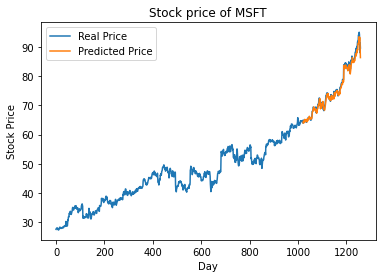

movement accuracy: 57.383966244725734%
Average mean squared error for training data: 79.92018182906523
Average mean squared error for testing data: 100.89540046925083
Average movement accuracy for 500 companies 49.86886056684407%


In [242]:
company_accuracy(df, 'MSFT', sc)
companies_accuracy(df, 500)

In [ ]:
model.save('/content/new')

INFO:tensorflow:Assets written to: /content/new/assets
